In [1]:
import pandas as pd
import torch
import re
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from torch.utils.data import Dataset

C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading our dataset
df = pd.read_csv("train.csv")
df.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [3]:
import re

# Functioning to clean text
def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  
    return text

# Appling the function to clean the 'Context' and 'Response' columns
df["Cleaned_Questions"] = df["Context"].apply(clean_text)
df["Cleaned_Answers"] = df["Response"].apply(clean_text)

# Displaying processed data
df.head()

,Context,Response,Cleaned_Questions,Cleaned_Answers
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb...",im going through some things with my feelings ...,if everyone thinks youre worthless then maybe ...
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see...",im going through some things with my feelings ...,hello and thank you for your question and seek...
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...,im going through some things with my feelings ...,first thing id suggest is getting the sleep yo...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...,im going through some things with my feelings ...,therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...,im going through some things with my feelings ...,i first want to let you know that you are not ...


In [4]:
# Loading GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Adding special tokens
tokenizer.add_special_tokens({"sep_token": "[SEP]", "pad_token": "[PAD]"})  

# Formating dataset as "question [SEP] answer"
df["Formatted_Text"] = df["Cleaned_Questions"] + " [SEP] " + df["Cleaned_Answers"]

df["Formatted_Text"] = df["Formatted_Text"].fillna("")

df["Formatted_Text"] = df["Formatted_Text"].astype(str)

# Check for the first few rows of the cleaned column
df["Formatted_Text"].head()


0    im going through some things with my feelings ...
1    im going through some things with my feelings ...
2    im going through some things with my feelings ...
3    im going through some things with my feelings ...
4    im going through some things with my feelings ...
Name: Formatted_Text, dtype: object

In [5]:
# Tokenize dataset with proper padding
encodings = tokenizer(
    df["Formatted_Text"].tolist(),
    padding=True,  
    truncation=True,
    max_length=128,
    return_tensors="pt"
)
encodings.keys()

dict_keys(['input_ids', 'attention_mask'])

In [6]:
class MentalHealthDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = encodings["input_ids"]
        self.attention_mask = encodings["attention_mask"]
        
        # Labels are same as input_ids 
        self.labels = encodings["input_ids"]  
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx], 
        }

# Creating dataset with labels
dataset = MentalHealthDataset(encodings)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Training: 2809, Validation: 351, Test: 352


In [8]:
# Loading GPT-2 model with text generation head
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Resizing our token embeddings 
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50259, 768)

In [9]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_mental_health_128",
    evaluation_strategy="epoch",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=25,
    learning_rate=5e-5,
    save_steps=500,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()

  0%|          | 0/7025 [00:00<?, ?it/s]C:\Users\Devashish Uniyal\AppData\Roaming\Python\Python310\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
                                                  
  4%|▍         | 281/7025 [02:02<46:04,  2.44it/s]

{'eval_loss': 2.909649133682251, 'eval_runtime': 4.4267, 'eval_samples_per_second': 79.291, 'eval_steps_per_second': 8.132, 'epoch': 1.0}


  7%|▋         | 500/7025 [03:35<45:14,  2.40it/s]  

{'loss': 3.1847, 'grad_norm': 6.406774520874023, 'learning_rate': 4.644128113879004e-05, 'epoch': 1.78}


                                                    
  8%|▊         | 562/7025 [04:09<43:54,  2.45it/s]

{'eval_loss': 2.632554054260254, 'eval_runtime': 4.434, 'eval_samples_per_second': 79.162, 'eval_steps_per_second': 8.119, 'epoch': 2.0}


                                                    
 12%|█▏        | 843/7025 [06:13<42:25,  2.43it/s]

{'eval_loss': 2.4397201538085938, 'eval_runtime': 4.4412, 'eval_samples_per_second': 79.032, 'eval_steps_per_second': 8.106, 'epoch': 3.0}


 14%|█▍        | 1000/7025 [07:20<43:21,  2.32it/s] 

{'loss': 2.4005, 'grad_norm': 5.478806972503662, 'learning_rate': 4.2882562277580074e-05, 'epoch': 3.56}


                                                     
 16%|█▌        | 1124/7025 [08:22<40:33,  2.43it/s]

{'eval_loss': 2.284092664718628, 'eval_runtime': 4.5012, 'eval_samples_per_second': 77.979, 'eval_steps_per_second': 7.998, 'epoch': 4.0}


                                                     
 20%|██        | 1405/7025 [10:26<38:37,  2.42it/s]

{'eval_loss': 2.1562869548797607, 'eval_runtime': 4.6253, 'eval_samples_per_second': 75.887, 'eval_steps_per_second': 7.783, 'epoch': 5.0}


 21%|██▏       | 1500/7025 [11:07<38:31,  2.39it/s]  

{'loss': 1.9827, 'grad_norm': 5.110204696655273, 'learning_rate': 3.932384341637011e-05, 'epoch': 5.34}


                                                     
 24%|██▍       | 1686/7025 [12:37<37:55,  2.35it/s]

{'eval_loss': 2.0703060626983643, 'eval_runtime': 4.4608, 'eval_samples_per_second': 78.685, 'eval_steps_per_second': 8.07, 'epoch': 6.0}


                                                     
 28%|██▊       | 1967/7025 [14:43<35:35,  2.37it/s]

{'eval_loss': 1.9929710626602173, 'eval_runtime': 4.422, 'eval_samples_per_second': 79.376, 'eval_steps_per_second': 8.141, 'epoch': 7.0}


 28%|██▊       | 2000/7025 [14:57<36:31,  2.29it/s]  

{'loss': 1.6913, 'grad_norm': 4.749814510345459, 'learning_rate': 3.5765124555160145e-05, 'epoch': 7.12}


                                                     
 32%|███▏      | 2248/7025 [16:53<32:12,  2.47it/s]

{'eval_loss': 1.9318366050720215, 'eval_runtime': 4.5367, 'eval_samples_per_second': 77.368, 'eval_steps_per_second': 7.935, 'epoch': 8.0}


 36%|███▌      | 2500/7025 [18:39<31:26,  2.40it/s]  

{'loss': 1.4562, 'grad_norm': 4.715827465057373, 'learning_rate': 3.2206405693950184e-05, 'epoch': 8.9}


                                                     
 36%|███▌      | 2529/7025 [19:02<30:57,  2.42it/s]

{'eval_loss': 1.8865810632705688, 'eval_runtime': 4.3914, 'eval_samples_per_second': 79.929, 'eval_steps_per_second': 8.198, 'epoch': 9.0}


                                                     
 40%|████      | 2810/7025 [21:04<28:30,  2.46it/s]

{'eval_loss': 1.8367373943328857, 'eval_runtime': 4.3938, 'eval_samples_per_second': 79.885, 'eval_steps_per_second': 8.193, 'epoch': 10.0}


 43%|████▎     | 3000/7025 [22:25<29:57,  2.24it/s]  

{'loss': 1.2635, 'grad_norm': 4.20013952255249, 'learning_rate': 2.8647686832740217e-05, 'epoch': 10.68}


                                                     
 44%|████▍     | 3091/7025 [23:14<27:21,  2.40it/s]

{'eval_loss': 1.8045817613601685, 'eval_runtime': 4.3794, 'eval_samples_per_second': 80.148, 'eval_steps_per_second': 8.22, 'epoch': 11.0}


                                                     
 48%|████▊     | 3372/7025 [25:17<25:12,  2.41it/s]

{'eval_loss': 1.7691593170166016, 'eval_runtime': 4.3866, 'eval_samples_per_second': 80.016, 'eval_steps_per_second': 8.207, 'epoch': 12.0}


 50%|████▉     | 3500/7025 [26:11<23:59,  2.45it/s]  

{'loss': 1.1333, 'grad_norm': 4.360058784484863, 'learning_rate': 2.5088967971530253e-05, 'epoch': 12.46}


                                                     
 52%|█████▏    | 3653/7025 [27:25<23:27,  2.40it/s]

{'eval_loss': 1.727948784828186, 'eval_runtime': 4.6888, 'eval_samples_per_second': 74.859, 'eval_steps_per_second': 7.678, 'epoch': 13.0}


                                                     
 56%|█████▌    | 3934/7025 [29:28<22:15,  2.32it/s]

{'eval_loss': 1.6977049112319946, 'eval_runtime': 4.4631, 'eval_samples_per_second': 78.646, 'eval_steps_per_second': 8.066, 'epoch': 14.0}


 57%|█████▋    | 4000/7025 [29:57<22:10,  2.27it/s]  

{'loss': 1.0084, 'grad_norm': 3.80965518951416, 'learning_rate': 2.1530249110320285e-05, 'epoch': 14.23}


                                                     
 60%|██████    | 4215/7025 [31:37<19:03,  2.46it/s]

{'eval_loss': 1.692505955696106, 'eval_runtime': 4.426, 'eval_samples_per_second': 79.303, 'eval_steps_per_second': 8.134, 'epoch': 15.0}


                                                     
 64%|██████▍   | 4496/7025 [33:40<17:07,  2.46it/s]

{'eval_loss': 1.6680748462677002, 'eval_runtime': 4.3997, 'eval_samples_per_second': 79.778, 'eval_steps_per_second': 8.182, 'epoch': 16.0}


 64%|██████▍   | 4500/7025 [33:41<37:01,  1.14it/s]  

{'loss': 0.9199, 'grad_norm': 4.216216087341309, 'learning_rate': 1.797153024911032e-05, 'epoch': 16.01}


                                                     
 68%|██████▊   | 4777/7025 [35:48<15:10,  2.47it/s]

{'eval_loss': 1.6251636743545532, 'eval_runtime': 4.4097, 'eval_samples_per_second': 79.598, 'eval_steps_per_second': 8.164, 'epoch': 17.0}


 71%|███████   | 5000/7025 [37:22<14:06,  2.39it/s]  

{'loss': 0.842, 'grad_norm': 3.5879926681518555, 'learning_rate': 1.4412811387900358e-05, 'epoch': 17.79}


                                                     
 72%|███████▏  | 5058/7025 [37:58<13:39,  2.40it/s]

{'eval_loss': 1.6333122253417969, 'eval_runtime': 4.5205, 'eval_samples_per_second': 77.645, 'eval_steps_per_second': 7.964, 'epoch': 18.0}


                                                   
 76%|███████▌  | 5339/7025 [40:00<11:42,  2.40it/s]

{'eval_loss': 1.6164740324020386, 'eval_runtime': 4.4356, 'eval_samples_per_second': 79.132, 'eval_steps_per_second': 8.116, 'epoch': 19.0}


 78%|███████▊  | 5500/7025 [41:08<10:32,  2.41it/s]

{'loss': 0.7934, 'grad_norm': 3.935336112976074, 'learning_rate': 1.0854092526690392e-05, 'epoch': 19.57}


                                                   
 80%|████████  | 5620/7025 [42:08<09:44,  2.40it/s]

{'eval_loss': 1.6075870990753174, 'eval_runtime': 4.3428, 'eval_samples_per_second': 80.823, 'eval_steps_per_second': 8.29, 'epoch': 20.0}


                                                   
 84%|████████▍ | 5901/7025 [44:10<07:55,  2.36it/s]

{'eval_loss': 1.599441409111023, 'eval_runtime': 4.3574, 'eval_samples_per_second': 80.552, 'eval_steps_per_second': 8.262, 'epoch': 21.0}


 85%|████████▌ | 6000/7025 [44:52<07:09,  2.39it/s]

{'loss': 0.7459, 'grad_norm': 3.536102771759033, 'learning_rate': 7.295373665480428e-06, 'epoch': 21.35}


                                                   
 88%|████████▊ | 6182/7025 [46:19<05:38,  2.49it/s]

{'eval_loss': 1.5893869400024414, 'eval_runtime': 4.4165, 'eval_samples_per_second': 79.474, 'eval_steps_per_second': 8.151, 'epoch': 22.0}


                                                   
 92%|█████████▏| 6463/7025 [48:22<03:54,  2.39it/s]

{'eval_loss': 1.5915857553482056, 'eval_runtime': 4.4087, 'eval_samples_per_second': 79.615, 'eval_steps_per_second': 8.166, 'epoch': 23.0}


 93%|█████████▎| 6500/7025 [48:39<03:46,  2.32it/s]

{'loss': 0.7208, 'grad_norm': 3.684075355529785, 'learning_rate': 3.7366548042704624e-06, 'epoch': 23.13}


                                                   
 96%|█████████▌| 6744/7025 [50:31<02:00,  2.34it/s]

{'eval_loss': 1.5823169946670532, 'eval_runtime': 4.402, 'eval_samples_per_second': 79.737, 'eval_steps_per_second': 8.178, 'epoch': 24.0}


100%|█████████▉| 7000/7025 [52:18<00:10,  2.38it/s]

{'loss': 0.7, 'grad_norm': 3.3347115516662598, 'learning_rate': 1.779359430604982e-07, 'epoch': 24.91}


                                                   
100%|██████████| 7025/7025 [52:44<00:00,  2.22it/s]

{'eval_loss': 1.5847275257110596, 'eval_runtime': 4.5097, 'eval_samples_per_second': 77.831, 'eval_steps_per_second': 7.983, 'epoch': 25.0}
{'train_runtime': 3164.1763, 'train_samples_per_second': 22.194, 'train_steps_per_second': 2.22, 'train_loss': 1.343723090772527, 'epoch': 25.0}


TrainOutput(global_step=7025, training_loss=1.343723090772527, metrics={'train_runtime': 3164.1763, 'train_samples_per_second': 22.194, 'train_steps_per_second': 2.22, 'total_flos': 4587308236800000.0, 'train_loss': 1.343723090772527, 'epoch': 25.0})

In [ ]:
# Get the total size of the dataset
dataset_size = len(test_dataset)

# Set subset size 
subset_size = min(1000, dataset_size)

# Create subset safely
small_test_dataset = torch.utils.data.Subset(test_dataset, range(subset_size))

# Run evaluation on the data
trainer.evaluate(small_test_dataset)


100%|██████████| 36/36 [00:04<00:00,  8.20it/s]


{'eval_loss': 1.5453568696975708,
 'eval_runtime': 4.4775,
 'eval_samples_per_second': 78.615,
 'eval_steps_per_second': 8.04,
 'epoch': 25.0}

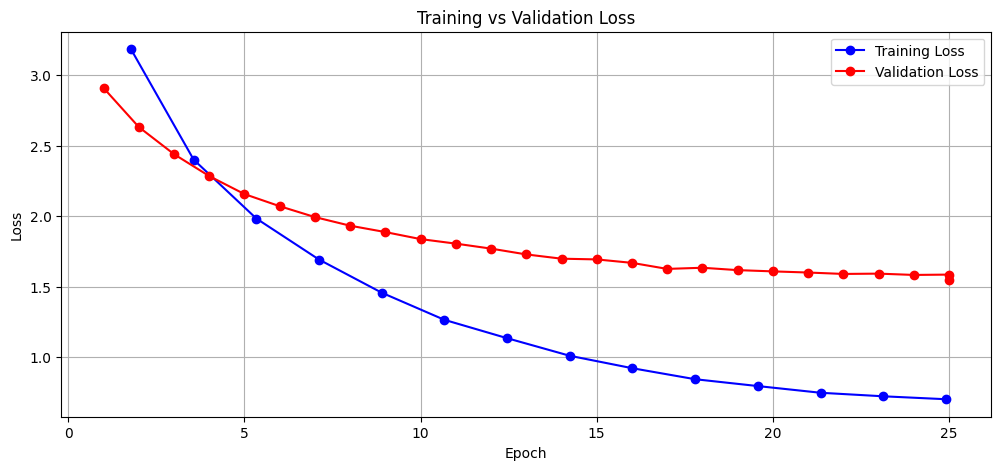

In [12]:
import matplotlib.pyplot as plt

history = trainer.state.log_history
train_data = [(log['epoch'], log['loss']) for log in history if 'loss' in log]
eval_data = [(log['epoch'], log['eval_loss']) for log in history if 'eval_loss' in log]

train_epochs, train_losses = zip(*train_data) if train_data else ([], [])
eval_epochs, eval_losses = zip(*eval_data) if eval_data else ([], [])

plt.figure(figsize=(12, 5))
plt.plot(train_epochs, train_losses, 'b-o', label='Training Loss')
plt.plot(eval_epochs, eval_losses, 'r-o', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.savefig("training_progress.png", dpi=300)
plt.show()


In [13]:
import evaluate

# Load the ROUGE and BLEU metrics
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")

# Define a function for generating predictions
def generate_predictions(model, tokenizer, dataset):
    model.eval()
    predictions = []
    references = []
    
    for idx in range(len(dataset)):
        input_ids = dataset[idx]['input_ids'].unsqueeze(0).to(model.device)  # Add batch dimension and move to device
        attention_mask = dataset[idx]['attention_mask'].unsqueeze(0).to(model.device)
        
        # Generate prediction with explicit pad_token_id
        outputs = model.generate(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        max_new_tokens=50,  # Limit the number of new tokens generated
        pad_token_id=tokenizer.eos_token_id  # Explicitly set the pad token ID
)

        pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Get the actual text from the dataset
        target_text = tokenizer.decode(dataset[idx]['labels'], skip_special_tokens=True)
        
        predictions.append(pred_text)
        references.append([target_text])  
    
    return predictions, references

# Generate predictions and references
predictions, references = generate_predictions(model, tokenizer, small_test_dataset)

# Compute ROUGE and BLEU scores
rouge_score = rouge.compute(predictions=predictions, references=references)
bleu_score = bleu.compute(predictions=predictions, references=references)

# Printing the scores
print("ROUGE Score:", rouge_score)
print("BLEU Score:", bleu_score)

Using the latest cached version of the module from C:\Users\Devashish Uniyal\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--rouge\b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Tue Apr  1 16:04:22 2025) since it couldn't be found locally at evaluate-metric--rouge, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Devashish Uniyal\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--bleu\9e0985c1200e367cce45605ce0ecb5ede079894e0f24f54613fca08eeb8aff76 (last modified on Tue Apr  1 16:04:26 2025) since it couldn't be found locally at evaluate-metric--bleu, or remotely on the Hugging Face Hub.


ROUGE Score: {'rouge1': 0.8313995056983627, 'rouge2': 0.8301604094959134, 'rougeL': 0.8315793303699427, 'rougeLsum': 0.8315305399155732}
BLEU Score: {'bleu': 0.7137501249014199, 'precisions': [0.716464175009798, 0.7146749847621097, 0.7128630705394191, 0.7110098405897092], 'brevity_penalty': 1.0, 'length_ratio': 1.3955350039777248, 'translation_length': 56134, 'reference_length': 40224}


In [14]:
# Saving the  model & tokenizer
model.save_pretrained("mental_health_chatbot_gpt2")
tokenizer.save_pretrained("mental_health_chatbot_gpt2")

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [15]:
def chatbot_response(user_input):
    user_input = clean_text(user_input)
    input_text = user_input + " [SEP]"

    # Tokenizig the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Moving the input_ids to the same device as the model
    input_ids = input_ids.to(model.device)

    # Generating our response
    output = model.generate(input_ids, max_length=100, pad_token_id=tokenizer.eos_token_id)

    # Decoding the generated response
    response = tokenizer.decode(output[:, input_ids.shape[-1]:][0], skip_special_tokens=True)
    return response

# Testing our chatbot
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    response = chatbot_response(user_input)
    print(f"Chatbot: {response}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Chatbot:  i am so sorry you are feeling down  i will admit that i am a little overwhelmed with emotions right now  i have been dealing with this since day one  i have been here first and im glad i did it was a big step at the time  now though i am going back to basics  basic eating can be hard but sometimes its not a physical need  if you are feeling down today then i
Chatbot:  i recommend a balanced diet based on whole grains and fish fish fish oil and butter  most people seem to enjoy eating a balanced diet but i find that those with a high intake of saturated fat and sugar may be having a different reaction than those who do not  if you are concerned about your saturated fat and sugar intake try eating a balanced diet with fruits and vegetables and legumes  these will help you feel full and not have to worry
